In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
api_calls_day = pd.Timestamp('2019-06-13')
churn_cutoff = api_calls_day - pd.Timedelta(3,'M')

In [3]:
df_friend_summary = pd.read_csv('100k_friend_summary.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_profile_summary = pd.read_csv('100k_clean_player_info.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_per_game_summary = pd.read_csv('100k_per_game.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_game_per_user_summary = pd.read_csv('100k_game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_top5game_per_user_summary = pd.read_csv('100k_top5game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [4]:
df_full_prof = df_friend_summary.merge(df_profile_summary,on='steamid',how='right')

In [5]:
df_full_prof = df_full_prof.drop(['lastlogoff_readable','timecreated_readable','newest_friend_steamid', 'oldest_friend_steamid', 'Root', 'First_tier', 'Second_tier', 'Third_tier','realname', 'personaname', 'loccityid', 'loccountrycode', 'locstatecode'],axis='columns')

In [6]:
df_full_prof = df_full_prof.merge(df_game_per_user_summary,on='steamid',how='left')

In [7]:
df_full_prof.fillna(0,inplace=True)

In [8]:
print(churn_cutoff)

2019-03-13 16:32:42


In [9]:
df_full_prof['isChurned'] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0)


In [10]:
df_friend_full = pd.read_csv('player_friend_info_100k.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [11]:
df_friend_full = df_friend_full[pd.to_datetime(df_friend_full['friend_since'], unit='s') < churn_cutoff]

In [12]:
df_friend_large = pd.merge(df_friend_full,df_full_prof,on='steamid')

In [13]:
df_friend_large = df_friend_large.drop(['relationship','friend_since','newest_friend_time','oldest_friend_time','lastlogoff','profilestate','timecreated','isPublic','isFriendsOnly','isPrivate','playtime_forever_max','playtime_forever_std','playtime_forever_std_noZero'],axis='columns')


In [14]:
df_friends_list = pd.DataFrame(df_friend_large.groupby('steamid_orig')['steamid'].apply(list))

In [15]:
df_friends_list = df_friends_list.add_suffix('_friend_list')
df_friends_list = df_friends_list.reset_index()
df_friends_list['steamid'] = df_friends_list['steamid_orig']
df_friends_list = df_friends_list.drop('steamid_orig',axis='columns')

In [16]:
df_friends_mean = pd.DataFrame(df_friend_large.drop(['steamid','appid_max'],axis='columns').groupby('steamid_orig').mean())

In [17]:
df_friends_mean = df_friends_mean.add_suffix('_friends_mean')

In [18]:
df_friends_mean = df_friends_mean.reset_index()
df_friends_mean['steamid'] = df_friends_mean['steamid_orig']
df_friends_mean = df_friends_mean.drop('steamid_orig',axis='columns')

In [19]:
df_friends_mode = pd.DataFrame(df_friend_large[df_friend_large['appid_max'] != 0].groupby('steamid_orig')['appid_max'].apply(pd.Series.mode))

In [20]:
df_friends_mode = df_friends_mode.reset_index().drop('level_1',axis='columns')
df_friends_mode['steamid'] = df_friends_mode['steamid_orig']
df_friends_mode['friends_fav_appid'] = df_friends_mode['appid_max']
df_friends_mode = df_friends_mode.drop('steamid_orig',axis='columns')
df_friends_mode = df_friends_mode.drop('appid_max',axis='columns')
df_friends_mode = df_friends_mode.drop_duplicates(['steamid'],keep='first')
df_friends_mode.info()
print(df_friends_mode['steamid'].nunique())
print(df_friends_mean['steamid'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65214 entries, 0 to 105551
Data columns (total 2 columns):
steamid              65214 non-null int64
friends_fav_appid    65214 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
65214
84637


In [21]:
df_friends_stats = pd.merge(df_friends_mean,df_friends_mode,on='steamid',how='outer')

In [22]:
df_friends_temp = df_full_prof.merge(df_friends_stats,on='steamid',how='left')

In [23]:
df_friends_temp['steamid'].nunique()

88555

In [24]:
df_dup_steamid = df_friends_temp[df_friends_temp.duplicated(['steamid'],keep=False)]

In [25]:
df_dup_steamid

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,commentpermission_friends_mean,costom_avatar_friends_mean,inClan_friends_mean,playtime_forever_sum_friends_mean,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid


In [26]:
df_friends_temp.fillna(0,inplace=True)

In [27]:
df_friends_temp['Same_fav_as_friend'] = df_friends_temp.apply(lambda x: 1 if x['appid_max'] == x['friends_fav_appid'] else 0,axis=1)

In [28]:
df_friends_temp['num_Zero_games'] = df_friends_temp['appid_count'] - df_friends_temp['appid_count_noZero']

In [29]:
df_full_prof = df_friends_temp

In [30]:
df_churned = df_full_prof[df_full_prof['isChurned'] == 1]

In [31]:
df_active = df_full_prof[df_full_prof['isChurned'] == 0]

In [32]:
from sklearn.model_selection import train_test_split
df_churned_train, df_churned_test = train_test_split(df_churned,test_size=0.2,random_state=1234)

In [33]:
df_active_remain, df_active_test = train_test_split(df_active,test_size=0.2,random_state=1234)

In [34]:
df_active_extra, df_active_train = train_test_split(df_active_remain,test_size=len(df_churned_train),random_state=1234)

In [35]:
df_train = pd.concat([df_active_train,df_churned_train])

In [36]:
df_test = pd.concat([df_active_test,df_churned_test])

In [37]:
X_train = df_train.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean'],axis='columns')
X_test = df_test.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean'],axis='columns')
y_train = df_train['isChurned']
y_test = df_test['isChurned']

In [38]:
X_train.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'inClan_friends_mean',
       'playtime_forever_sum_friends_mean', 'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [40]:
log_model = LogisticRegression(random_state=10,solver='lbfgs',C=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [41]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate

[[0.84905149 0.15094851]
 [0.25158085 0.74841915]]


              precision    recall  f1-score   support

           0       0.77      0.85      0.81     11070
           1       0.83      0.75      0.79     11070

   micro avg       0.80      0.80      0.80     22140
   macro avg       0.80      0.80      0.80     22140
weighted avg       0.80      0.80      0.80     22140



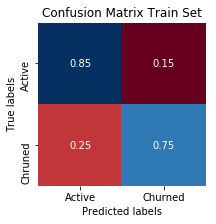

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_train_scaled)
cm = confusion_matrix(y_train,log_pred)
cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='0.2f',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Train Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

[[12734  2210]
 [  727  2041]]


              precision    recall  f1-score   support

           0       0.95      0.85      0.90     14944
           1       0.48      0.74      0.58      2768

   micro avg       0.83      0.83      0.83     17712
   macro avg       0.71      0.79      0.74     17712
weighted avg       0.87      0.83      0.85     17712



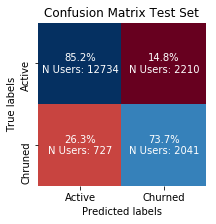

In [43]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test,log_pred)
cm_perc = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        annot[i, j] = '%.1f%%\nN Users: %d' % (p*100, c)
ax = plt.subplot()
sns.heatmap(cm_perc, annot=annot, fmt='',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

In [44]:
df_train['Prob_Churn'] = log_model.predict_proba(X_train_scaled)[:,1]
df_test['Prob_Churn'] = log_model.predict_proba(X_test_scaled)[:,1]

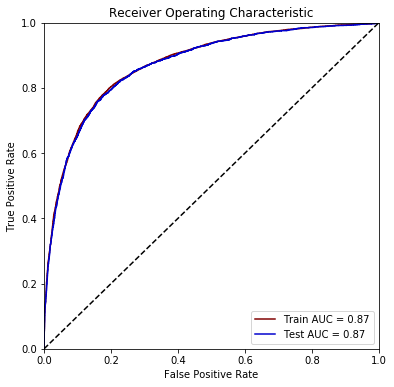

In [45]:
from sklearn import metrics
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, df_train['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, df_test['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'mediumblue',label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

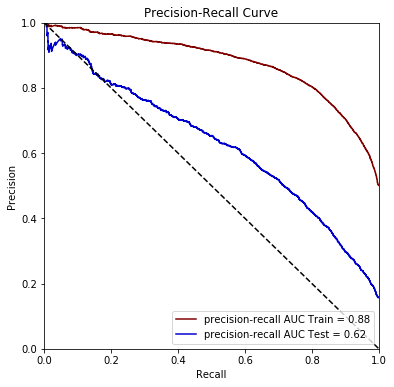

In [46]:
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train, df_train['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(recall_train, precision_train)
precision_test, recall_test, threshold_test = metrics.precision_recall_curve(y_test, df_test['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(recall_test, precision_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve')
plt.plot(recall_train, precision_train, 'maroon', label = 'precision-recall AUC Train = %0.2f' % roc_auc_train)
plt.plot(recall_test, precision_test, 'mediumblue', label = 'precision-recall AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

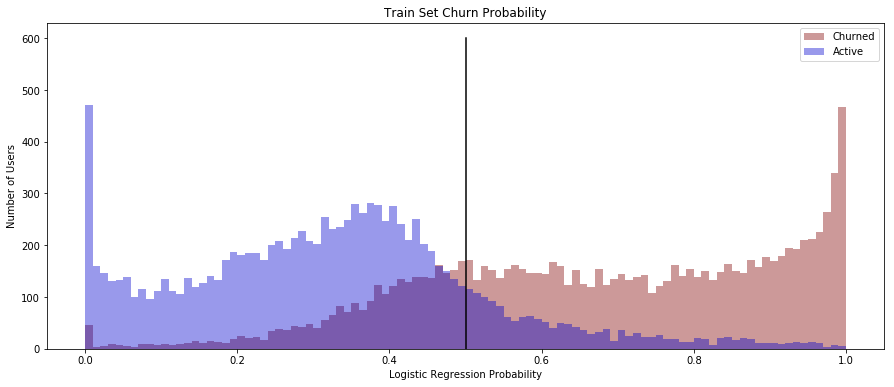

In [47]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_train['Prob_Churn'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train['Prob_Churn'][df_train['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 600],'k')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

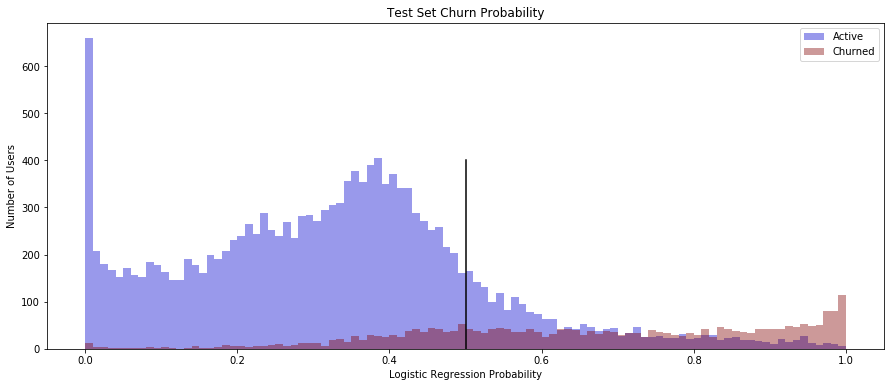

In [48]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_test['Prob_Churn'][df_test['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_test['Prob_Churn'][df_test['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 400],'k')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Test Set Churn Probability")
plt.show()

In [49]:
feature_dict = {}
for i in range(0,len(log_model.coef_[0])):
    feature_dict[X_train.columns[i]] = abs(log_model.coef_[0][i])

In [50]:
import operator
features_sorted = sorted(feature_dict.items(), key=operator.itemgetter(1))

In [51]:
print(features_sorted)

[('playtime_forever_mean_noZero_friends_mean', 0.008028591227704017), ('playtime_forever_std_noZero', 0.012488696217013451), ('appid_count_noZero_friends_mean', 0.012588854681020311), ('commentpermission', 0.01890273494801874), ('num_Zero_games', 0.022308354565338785), ('playtime_forever_sum_friends_mean', 0.02297757363190247), ('num_Friends_friends_mean', 0.03680784805968427), ('playtime_forever_std', 0.04427101542489702), ('Same_fav_as_friend', 0.07801505815545481), ('costom_avatar_friends_mean', 0.10869464959142529), ('costom_avatar', 0.12417204484246532), ('playtime_forever_mean_noZero', 0.12564985808968948), ('oldest_friend_time', 0.12865291246020946), ('profilestate', 0.18922106448995152), ('timecreated', 0.19456018538354372), ('playtime_forever_sum', 0.2153006683397124), ('num_Friends', 0.251845074553313), ('appid_count_noZero', 0.7640126133517864), ('playtime_forever_max', 0.7881186098308385), ('inClan_friends_mean', 4.638925189223487), ('newest_friend_time', 4.853549832262385)

# Tune Regularizaion parameter

In [52]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [53]:
my_Cs = [0.001,0.003,0.01,0.03,0.1,0.3,1.0]
bal_acc_test = []
bal_acc_train = []
acc_test = []
acc_train = []
for C in my_Cs:
    log_model = LogisticRegression(random_state=10,solver='lbfgs',C=C)
    log_model.fit(X_train_scaled,y_train)
    y_pred_test = log_model.predict(X_test_scaled)
    y_pred_train = log_model.predict(X_train_scaled)
    bal_acc_test.append(balanced_accuracy_score(y_pred_test,y_test))
    bal_acc_train.append(balanced_accuracy_score(y_pred_train,y_train))
    acc_test.append(accuracy_score(y_pred_test,y_test))
    acc_train.append(accuracy_score(y_pred_train,y_train))

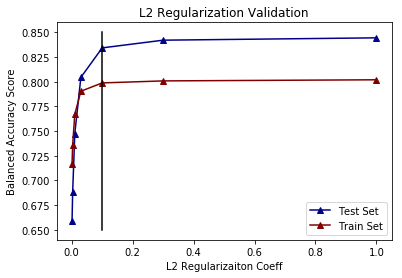

In [54]:
plt.plot(my_Cs, acc_test,color='darkblue',marker='^',label='Test Set')
plt.plot(my_Cs, acc_train,color='maroon',marker='^',label='Train Set')
plt.legend()
plt.plot([0.1, 0.1], [0.65, 0.85],'k')
plt.ylabel("Balanced Accuracy Score")
plt.xlabel("L2 Regularizaiton Coeff")
plt.title("L2 Regularization Validation")
plt.show()

# Learning curve

In [55]:
my_fracs = [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
learning_train = []
learning_test = []
bal_learning_train = []
bal_learning_test = []
for frac in my_fracs:
    log_model = LogisticRegression(random_state=10,solver='lbfgs',C=0.1)
    X_train_scaled_extra, X_train_scaled_frac, y_train_extra, y_train_frac = train_test_split(X_train_scaled,y_train,test_size=frac,shuffle=True,stratify=y_train)
    log_model.fit(X_train_scaled_frac,y_train_frac)
    y_pred_test = log_model.predict(X_test_scaled)
    y_pred_train = log_model.predict(X_train_scaled_frac)
    bal_learning_test.append(balanced_accuracy_score(y_pred_test,y_test))
    bal_learning_train.append(balanced_accuracy_score(y_pred_train,y_train_frac))
    learning_test.append(accuracy_score(y_pred_test,y_test))
    learning_train.append(accuracy_score(y_pred_train,y_train_frac))
    
    

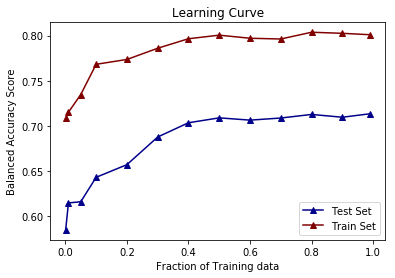

In [56]:
plt.plot(my_fracs, bal_learning_test,color='darkblue',marker='^',label='Test Set')
plt.plot(my_fracs, bal_learning_train,color='maroon',marker='^',label='Train Set')
plt.legend()
plt.ylabel("Balanced Accuracy Score")
plt.xlabel("Fraction of Training data")
plt.title("Learning Curve")
plt.show()

# Calculate Average Prob of Friends

In [57]:
df_friend_full.head()

,friend_since,relationship,steamid,steamid_orig
0,1434524498,friend,76561198007070703,76561198199710782
1,1437740667,friend,76561198041503217,76561198199710782
2,1438264541,friend,76561198238259518,76561198199710782
3,1421677696,friend,76561197960448312,76561198049785932
4,1490267324,friend,76561197961426758,76561198049785932


In [58]:
X_full_scaled = scaler.transform(df_full_prof[X_train.columns])
df_full_prof['Prob_Churned'] = log_model.predict_proba(X_full_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


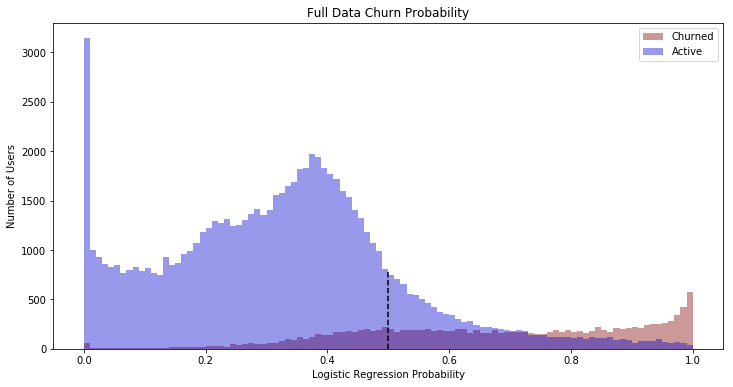

In [59]:
axis = plt.figure(figsize=(12,6))
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability")
plt.show()

[[0.85259044 0.14740956]
 [0.25458881 0.74541119]]


              precision    recall  f1-score   support

           0       0.95      0.85      0.90     74717
           1       0.48      0.75      0.59     13838

   micro avg       0.84      0.84      0.84     88555
   macro avg       0.72      0.80      0.74     88555
weighted avg       0.88      0.84      0.85     88555



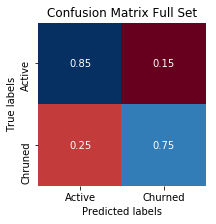

In [60]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_full_scaled)
cm = confusion_matrix(df_full_prof['isChurned'],log_pred)
cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='0.2f',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Full Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(df_full_prof['isChurned'],log_pred))

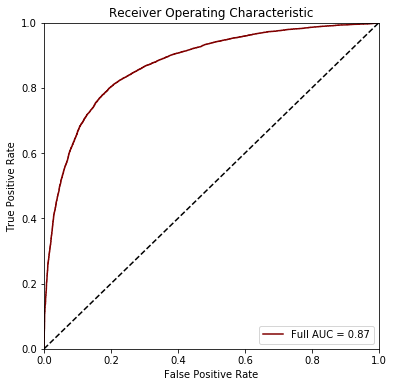

In [61]:
fpr_full, tpr_full, threshold_full = metrics.roc_curve(df_full_prof['isChurned'], df_full_prof['Prob_Churned'], pos_label=1)
roc_auc_full = metrics.auc(fpr_full, tpr_full)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'Full AUC = %0.2f' % roc_auc_full)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
df_friend_prob = pd.merge(df_friend_full,df_full_prof[['steamid','Prob_Churned']],on='steamid')

In [63]:
df_friend_prob.head()

,friend_since,relationship,steamid,steamid_orig,Prob_Churned
0,1434524498,friend,76561198007070703,76561198199710782,0.194375
1,1455556043,friend,76561198007070703,76561198119327769,0.194375
2,1488713631,friend,76561198007070703,76561198302636934,0.194375
3,1424045974,friend,76561198007070703,76561198035000472,0.194375
4,1403982908,friend,76561198007070703,76561198022371464,0.194375


In [64]:
df_friend_prob = df_friend_prob.drop(['friend_since','relationship'],axis='columns')

In [65]:
df_friends_prob_mean = pd.DataFrame(df_friend_prob.drop(['steamid'],axis='columns').groupby('steamid_orig').mean())

In [66]:
df_friends_prob_mean.head()

,Prob_Churned
steamid_orig,
76561197960265730,0.309063
76561197960265731,0.336681
76561197960265733,0.375774
76561197960265738,0.438336
76561197960265743,0.496083


In [67]:
df_friends_prob_mean = df_friends_prob_mean.add_suffix('_friends_mean')

In [68]:
df_friends_prob_mean = df_friends_prob_mean.reset_index()
df_friends_prob_mean['steamid'] = df_friends_prob_mean['steamid_orig']
df_friends_prob_mean = df_friends_prob_mean.drop('steamid_orig',axis='columns')

In [69]:
df_friends_prob_mean.head()

,Prob_Churned_friends_mean,steamid
0,0.309063,76561197960265730
1,0.336681,76561197960265731
2,0.375774,76561197960265733
3,0.438336,76561197960265738
4,0.496083,76561197960265743


In [70]:
df_friends_big = df_full_prof.merge(df_friends_prob_mean,on='steamid',how='left')

In [71]:
df_friends_big.head()

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid,Same_fav_as_friend,num_Zero_games,Prob_Churned,Prob_Churned_friends_mean
0,9.0,76561197960265730,1.455907e+09,1.347314e+09,0.0,1.560120e+09,1.0,1.063193e+09,1,1,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,1,0.0,0.728790,0.309063
1,174.0,76561197960265731,1.534047e+09,0.000000e+00,1.0,1.560203e+09,1.0,1.063192e+09,1,1,...,83.059524,24.914479,27.642857,67.770969,0.119048,72850.0,0,0.0,0.249922,0.336681
2,70.0,76561197960265733,1.498068e+09,0.000000e+00,0.0,1.547593e+09,1.0,1.063193e+09,1,1,...,78.785714,16.414644,40.309524,36.069376,0.095238,578080.0,0,0.0,0.419333,0.375774
3,91.0,76561197960265738,1.548740e+09,0.000000e+00,1.0,1.559372e+09,1.0,1.063233e+09,1,1,...,102.134328,42.687874,42.447761,101.412194,0.253731,72850.0,0,0.0,0.227334,0.438336
4,66.0,76561197960265743,1.534368e+09,0.000000e+00,0.0,1.557252e+09,1.0,1.063236e+09,1,1,...,95.062500,34.489156,48.750000,72.782834,0.291667,578080.0,0,0.0,0.258034,0.496083


In [72]:
df_friends_big[['isChurned_friends_mean','Prob_Churned_friends_mean','isChurned','Prob_Churned']].corr()

,isChurned_friends_mean,Prob_Churned_friends_mean,isChurned,Prob_Churned
isChurned_friends_mean,1.000000,0.513136,0.151958,0.202054
Prob_Churned_friends_mean,0.513136,1.000000,0.166360,0.321809
isChurned,0.151958,0.166360,1.000000,0.535975
Prob_Churned,0.202054,0.321809,0.535975,1.000000


In [73]:
for i in range(0,len(log_model.coef_[0])):
    print((X_train.columns[i],(log_model.coef_[0][i])))

('num_Friends', -0.2504394844306364)
('newest_friend_time', -4.828010434146208)
('oldest_friend_time', 0.12491727462385273)
('commentpermission', 0.019533984781919436)
('profilestate', -0.18881395691154873)
('timecreated', 0.1954629880832896)
('costom_avatar', -0.12572664644987522)
('playtime_forever_sum', 0.21569294573775635)
('playtime_forever_std', -0.04802050841496104)
('playtime_forever_max', -0.7798520941067988)
('appid_count_noZero', -0.7595954111447103)
('playtime_forever_mean_noZero', 0.12543851686721044)
('playtime_forever_std_noZero', 0.013071349250309986)
('num_Friends_friends_mean', -0.03835719657568312)
('costom_avatar_friends_mean', 0.1156157090806281)
('inClan_friends_mean', 4.608621834634274)
('playtime_forever_sum_friends_mean', -0.022374465913820776)
('appid_count_noZero_friends_mean', -0.013964911798199245)
('playtime_forever_mean_noZero_friends_mean', 0.009627774792880808)
('Same_fav_as_friend', 0.07683098392322647)
('num_Zero_games', 0.021631004239985426)


In [74]:
sorted_index = np.argsort(abs(log_model.coef_[0]))[::-1]

In [75]:
print(log_model.coef_[0][sorted_index])

[-4.82801043  4.60862183 -0.77985209 -0.75959541 -0.25043948  0.21569295
  0.19546299 -0.18881396 -0.12572665  0.12543852  0.12491727  0.11561571
  0.07683098 -0.04802051 -0.0383572  -0.02237447  0.021631    0.01953398
 -0.01396491  0.01307135  0.00962777]


In [76]:
X_train.columns[sorted_index]

Index(['newest_friend_time', 'inClan_friends_mean', 'playtime_forever_max',
       'appid_count_noZero', 'num_Friends', 'playtime_forever_sum',
       'timecreated', 'profilestate', 'costom_avatar',
       'playtime_forever_mean_noZero', 'oldest_friend_time',
       'costom_avatar_friends_mean', 'Same_fav_as_friend',
       'playtime_forever_std', 'num_Friends_friends_mean',
       'playtime_forever_sum_friends_mean', 'num_Zero_games',
       'commentpermission', 'appid_count_noZero_friends_mean',
       'playtime_forever_std_noZero',
       'playtime_forever_mean_noZero_friends_mean'],
      dtype='object')

In [77]:
df_friends_big['Add_Friend'] = df_friends_big['Prob_Churned']+0

In [78]:
df_friends_big['Play_owned_game'] = df_friends_big['Prob_Churned']+0

In [79]:
df_friends_big['Get_new_game'] = df_friends_big['Prob_Churned']+0

In [80]:
df_friends_big['Get_and_play_new_game'] = df_friends_big['Prob_Churned']+0

In [81]:
df_friends_big['Set_community_profile'] = df_friends_big['Prob_Churned']+0

In [82]:
df_friends_big['Play_friends_game'] = df_friends_big['Prob_Churned']+0

In [83]:
df_friends_big.head()

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,Same_fav_as_friend,num_Zero_games,Prob_Churned,Prob_Churned_friends_mean,Add_Friend,Play_owned_game,Get_new_game,Get_and_play_new_game,Set_community_profile,Play_friends_game
0,9.0,76561197960265730,1.455907e+09,1.347314e+09,0.0,1.560120e+09,1.0,1.063193e+09,1,1,...,1,0.0,0.728790,0.309063,0.728790,0.728790,0.728790,0.728790,0.728790,0.728790
1,174.0,76561197960265731,1.534047e+09,0.000000e+00,1.0,1.560203e+09,1.0,1.063192e+09,1,1,...,0,0.0,0.249922,0.336681,0.249922,0.249922,0.249922,0.249922,0.249922,0.249922
2,70.0,76561197960265733,1.498068e+09,0.000000e+00,0.0,1.547593e+09,1.0,1.063193e+09,1,1,...,0,0.0,0.419333,0.375774,0.419333,0.419333,0.419333,0.419333,0.419333,0.419333
3,91.0,76561197960265738,1.548740e+09,0.000000e+00,1.0,1.559372e+09,1.0,1.063233e+09,1,1,...,0,0.0,0.227334,0.438336,0.227334,0.227334,0.227334,0.227334,0.227334,0.227334
4,66.0,76561197960265743,1.534368e+09,0.000000e+00,0.0,1.557252e+09,1.0,1.063236e+09,1,1,...,0,0.0,0.258034,0.496083,0.258034,0.258034,0.258034,0.258034,0.258034,0.258034


In [84]:
df_friends_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88555 entries, 0 to 88554
Data columns (total 44 columns):
num_Friends                                  88555 non-null float64
steamid                                      88555 non-null int64
newest_friend_time                           88555 non-null float64
oldest_friend_time                           88555 non-null float64
commentpermission                            88555 non-null float64
lastlogoff                                   88555 non-null float64
profilestate                                 88555 non-null float64
timecreated                                  88555 non-null float64
costom_avatar                                88555 non-null int64
isPublic                                     88555 non-null int64
isFriendsOnly                                88555 non-null int64
isPrivate                                    88555 non-null int64
inClan                                       88555 non-null int64
playtime_forever_su

In [85]:
df_friends_small = df_friends_big[['steamid','Prob_Churned', 'Prob_Churned_friends_mean', 'Add_Friend', 'Play_owned_game', 'Get_new_game', 'Get_and_play_new_game', 'Set_community_profile', 'Play_friends_game']]

In [86]:
as_dict = df_friends_small.set_index('steamid').to_dict()

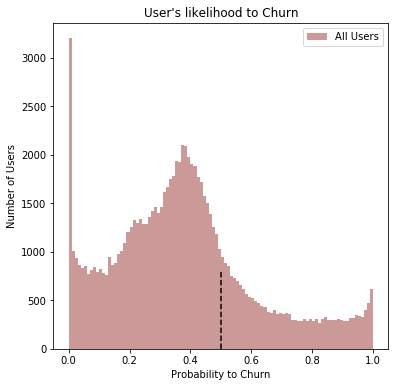

In [87]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [88]:
df_friends_big.loc[df_friends_big['steamid'] == 76561197960265730,'Prob_Churned'].to_list()[0]

0.7287898628788054

In [89]:
n = 0

In [90]:
import json
json = json.dumps(as_dict)
f = open("SteamChurn.json","w")
f.write(json)
f.close()

In [91]:
as_dict.keys()

dict_keys(['Prob_Churned', 'Prob_Churned_friends_mean', 'Add_Friend', 'Play_owned_game', 'Get_new_game', 'Get_and_play_new_game', 'Set_community_profile', 'Play_friends_game'])

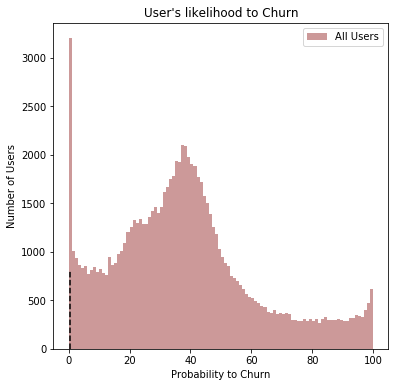

In [92]:
axis = plt.figure(figsize=(6,6))
sns.distplot( list(map(lambda x: x*100, list(as_dict.get('Prob_Churned').values()))) , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

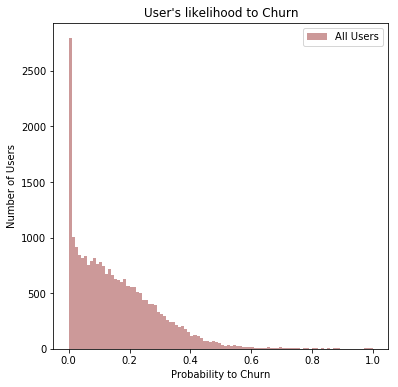

In [93]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['appid_count'] != 0] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

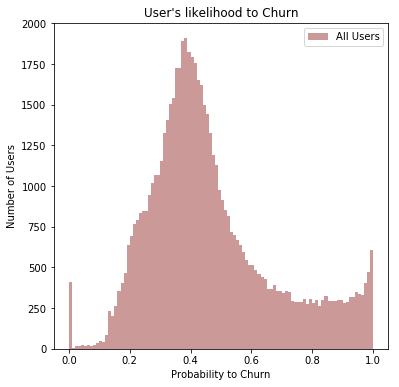

In [94]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['appid_count'] == 0] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [95]:
df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0).sum()

13838

In [96]:
list_churn_by_month = {}
api_calls_day = pd.Timestamp('2019-06-13')
for i in range(0,12):
    churn_cutoff = api_calls_day - pd.Timedelta(i,'M')
    list_churn_by_month[i] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0).sum()
print(list_churn_by_month)

{0: 55746, 1: 19168, 2: 15786, 3: 13838, 4: 12455, 5: 11346, 6: 10401, 7: 9757, 8: 9225, 9: 8740, 10: 8251, 11: 7788}


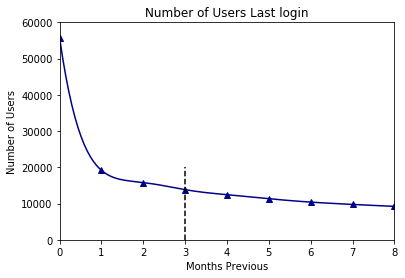

In [97]:

from scipy.interpolate import make_interp_spline, BSpline

lists = sorted(list_churn_by_month.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

x = np.array(x)
y = np.array(y)
xnew = np.linspace(x.min(),x.max(),300)
spl = make_interp_spline(x, y, k=5)
y_smooth = spl(xnew)

plt.plot(xnew, y_smooth,color='darkblue')
plt.plot(x,y,color='darkblue',marker='^',linestyle='None')
plt.xlim([0, 8])
plt.ylim([0, 60000])
plt.plot([3, 3], [0, 20000],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Months Previous")
plt.title("Number of Users Last login")
plt.show()

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


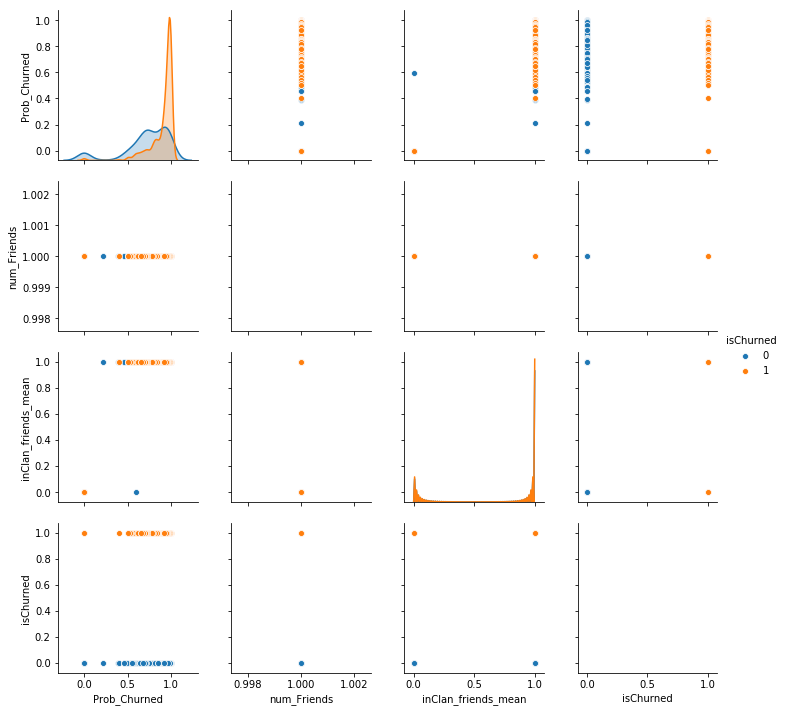

In [98]:
sns.pairplot(df_friends_big[['Prob_Churned','num_Friends','inClan_friends_mean','isChurned']][df_friends_big['num_Friends'] == 1],hue='isChurned')

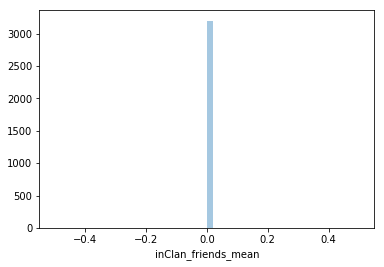

In [99]:
sns.distplot(df_friends_big['inClan_friends_mean'][df_friends_big['num_Friends'] == 0],kde=False)

In [100]:
df_friends_big['inClan_friends_mean'].describe()

count    88555.000000
mean         0.955756
std          0.205637
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: inClan_friends_mean, dtype: float64